In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/gdrive')

os.getcwd()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


'/content'

In [5]:
import os

directory_path = '/content/drive/MyDrive/AI stuff/kaggle/'
zip_file_name = 'celebahq-resized-256x256.zip'

# Complete path to storage location of the .zip file of data
zip_path = directory_path + zip_file_name

# Check current directory (be sure you're in the directory where Colab operates: '/content')
os.chdir('/content')
os.getcwd()

# Copy the .zip file into the present directory
!cp '/content/drive/MyDrive/AI stuff/kaggle/celebahq-resized-256x256.zip' .

# Unzip quietly 
!unzip -q 'celebahq-resized-256x256.zip'

# View the unzipped contents in the virtual machine
os.listdir()

['.config',
 'celeba_hq_256',
 'celebahq-resized-256x256.zip',
 'drive',
 'sample_data']

In [ ]:
os.getcwd()

'/content'

In [1]:
import tensorflow as tf
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, LeakyReLU, ReLU, BatchNormalization, Reshape, InputLayer, LayerNormalization
from tensorflow.keras.initializers import RandomNormal
import numpy as np

from IPython import display
import time


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
BATCH_SIZE = 64
Z_DIM = 128
INPUT_SHAPE = (64, 64, 3)
LAMBDA = 10 # regularizer weight for gradient penalty
N_CRIT = 5 # number of critic train steps per generator train step

In [6]:
data_path = "celeba_hq_256"

data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode=None, image_size=(64, 64), batch_size=BATCH_SIZE)

Found 30000 files belonging to 1 classes.


(64, 64, 64, 3)


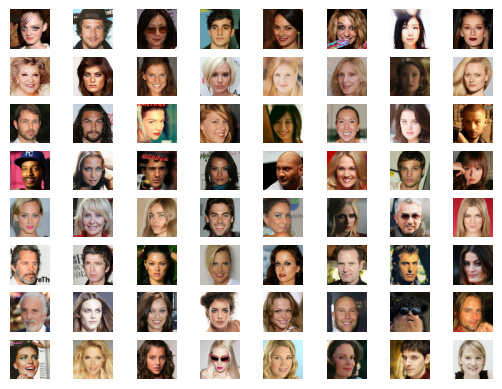

In [7]:
for batch in data.take(1):
    print(batch.shape)
    for i in range(BATCH_SIZE):
        axes = plt.subplot(8, 8, i+1)
        axes.imshow(batch[i].numpy().astype('uint8'))
        axes.axis("off")

In [8]:
sample_batch = next(iter(data))
print(sample_batch[i].numpy())

[[[ 60.    43.    97.  ]
  [ 61.    44.    98.  ]
  [ 61.    44.    98.  ]
  ...
  [168.25 183.75 228.25]
  [ 94.75  95.75 144.75]
  [ 47.25  39.25  91.75]]

 [[ 60.    43.    97.  ]
  [ 61.    44.    98.  ]
  [ 61.    44.    98.  ]
  ...
  [174.25 192.25 235.75]
  [ 77.75  76.75 126.75]
  [ 53.25  41.    94.75]]

 [[ 61.    44.    98.  ]
  [ 61.    44.    98.  ]
  [ 61.    44.    98.  ]
  ...
  [172.25 188.5  232.75]
  [105.5  106.5  155.5 ]
  [ 50.    42.    94.5 ]]

 ...

 [[180.25 165.25 136.25]
  [137.   122.    93.  ]
  [126.5  111.5   82.5 ]
  ...
  [143.25 133.   110.  ]
  [154.   140.25 113.  ]
  [110.75  93.    75.25]]

 [[158.   143.   114.  ]
  [145.   130.   101.  ]
  [145.75 130.75 101.75]
  ...
  [168.5  159.25 133.  ]
  [167.25 156.75 131.  ]
  [134.25 121.   109.25]]

 [[151.   136.   107.  ]
  [144.25 129.25 100.25]
  [166.   151.   122.  ]
  ...
  [156.25 149.25 120.75]
  [147.75 140.75 116.5 ]
  [111.   102.5   93.5 ]]]


In [9]:
# normalize images to [-1, 1]

def normalize_images(image):
    image = (image - 127.5) / 127.5
    return image

In [10]:
data = data.map(normalize_images)

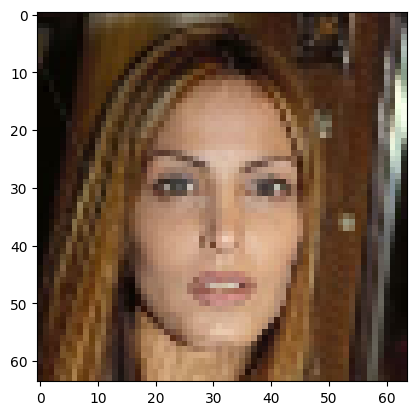

In [11]:
# view normalised image
sample_batch = next(iter(data))
plt.imshow(np.clip(sample_batch[0] * 0.5 + 0.5, 0, 1))

In [12]:
from keras.api._v2.keras import activations
class WGAN(tf.keras.Model):
    def __init__(self, gen_optimizer, crit_optimizer):
        super(WGAN, self).__init__()
        self.gen_optimizer = gen_optimizer
        self.crit_optimizer = crit_optimizer
        self.generator = self.create_generator()
        self.critic = self.create_critic()
        self.critic_loss = []
        self.gen_loss = []


    def create_generator(self):
        #print('in create gen')
        return tf.keras.Sequential(
            [
                InputLayer(Z_DIM, name='gen_input_layer'),
                #Dense(4 * 4 * 128, name='gen_dense_layer_1'),
                Reshape((2, 2, 32), name='gen_reshape_layer'), # 4*4*8 = Z_DIM. testing with directly reshaping z_dim input layer 
                Conv2DTranspose(1064, 3, strides=2, padding='same', output_padding=1, name='gen_conv_layer_1', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                BatchNormalization(),
                ReLU(),
                Conv2DTranspose(512, 3, strides=2, padding='same', output_padding=1, name='gen_conv_layer_2', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                BatchNormalization(),
                ReLU(),
                Conv2DTranspose(256, 3, strides=2, padding='same', output_padding=1, name='gen_conv_layer_3', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                BatchNormalization(),
                ReLU(),
                Conv2DTranspose(128, 3, strides=2, padding='same', output_padding=1, name='gen_conv_layer_4', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                BatchNormalization(),
                ReLU(),
                Conv2DTranspose(3, 3, strides=2, padding='same', output_padding=1, name='gen_conv_layer_5', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), activation='tanh'),
                # tanh activation so the output ranges between [-1, 1] just as preprocessed images
            ]
        )


    def create_critic(self):
        #print('in create critic')
        return tf.keras.Sequential(
            [
                InputLayer(input_shape=INPUT_SHAPE, name='crit_input_layer'),
                Conv2D(16, 3, strides=2, padding='same',  name='crit_conv_layer_1', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                LayerNormalization(),
                LeakyReLU(alpha=0.2),
                Conv2D(32, 3, strides=2, padding='same', name='crit_conv_layer_2', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                LayerNormalization(),
                LeakyReLU(alpha=0.2),
                Conv2D(64, 3, strides=2, padding='same', name='crit_conv_layer_3', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                LayerNormalization(),
                LeakyReLU(alpha=0.2),
                Conv2D(128, 3, strides=2, padding='same', name='crit_conv_layer_4', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                LayerNormalization(),
                LeakyReLU(alpha=0.2),
                Conv2D(256, 3, strides=2, padding='same', name='crit_conv_layer_5', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                LayerNormalization(),
                LeakyReLU(alpha=0.2),
                Flatten(),
                Dense(1),
            ]
        )


    @tf.function
    def train_step(self, x, current_batch_size):
        # Critic training
        for _ in range(N_CRIT):
            

            with tf.GradientTape(persistent=True) as tape_c:
                # generate noise with (BATCH_SIZE, Z_DIM) dimensions to generate fake image  
                noise = tf.random.normal((current_batch_size, Z_DIM))
                # epsilon for gradient penalty
                epsilon = tf.random.uniform(shape=(current_batch_size, 1, 1, 1), minval=0, maxval=1)
            
                # Calculate gradient Penalty
                with tf.GradientTape() as gp_t:  
                    x_gen = self.generator(noise)
                    interpolated_image = epsilon * x + (1 - epsilon) * x_gen # x_hat
                    gp_t.watch(interpolated_image)
                    c_interpolated = self.critic(interpolated_image) # c_hat
                grads = gp_t.gradient(c_interpolated, interpolated_image)
                l2_norm = tf.sqrt(tf.reduce_sum(grads ** 2, axis=(1, 2, 3)))
                gp = tf.reduce_mean((l2_norm - 1) ** 2) 
   
                #fake image
                critic_real = self.critic(x)
                critic_fake = self.critic(x_gen)

                # critic loss = C(x) - C(G(z)) + lambda*gp
                critic_loss = tf.reduce_mean(critic_fake) - tf.reduce_mean(critic_real) + LAMBDA * gp
                        
            # calculate gradients of critic and apply grads to critic 
            grads = tape_c.gradient(critic_loss, self.critic.trainable_variables)
            self.crit_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))
            self.critic_loss = critic_loss
                           
        # Generator training
        noise = tf.random.normal((current_batch_size, Z_DIM))
        with tf.GradientTape() as tape_g:
            x_gen = self.generator(noise)
            critic_fake = self.critic(x_gen)
                    
            # generator loss = -C(G(z))
            gen_loss =  -tf.reduce_mean(critic_fake)

        grads = tape_g.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        self.gen_loss = gen_loss
        #tf.print("critic loss: ", self.critic_loss) 
        #tf.print("gen loss: ", self.gen_loss) 
                

    def reset_critic_loss(self):
        self.critic_loss = []

    def reset_gen_loss(self):
        self.gen_loss = []

            

In [13]:
#noise to visualise the generated images during training

num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, Z_DIM])

In [14]:
gen_optimizer = tf.optimizers.Adam(learning_rate=1e-4, beta_1=0, beta_2=0.9)
crit_optimizer = tf.optimizers.Adam(learning_rate=1e-4, beta_1=0, beta_2=0.9)

wgan = WGAN(gen_optimizer, crit_optimizer)

In [21]:
def train(train_ds, epochs, epoch_start=0):
    for epoch in range(epoch_start, epoch_start + epochs):
        start_time = time.time()
        print("epoch: ", epoch)
        for batch in train_ds:
            wgan.train_step(x=batch, current_batch_size=batch.shape[0])
        
        # for generating images
        display.clear_output(wait=True)
        generate_and_save_images(wgan.generator, epoch + 1, seed)

        # save the model every 1 epochs
        if (epoch + 1) % 1 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start_time))
    
    display.clear_output(wait=True)
    generate_and_save_images(wgan.generator, epoch_start + epochs + 1, seed)
   


In [16]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(gen_optimizer=wgan.gen_optimizer, crit_optimizer=wgan.crit_optimizer, generator=wgan.generator, critic=wgan.critic)

In [17]:
# reference: https://www.tensorflow.org/tutorials/generative/dcgan

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.clip(predictions[i] * 0.5 + 0.5, 0, 1))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Display a single image using the epoch number
def display_image(epoch_no):
    return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [18]:
tf.debugging.set_log_device_placement(True)

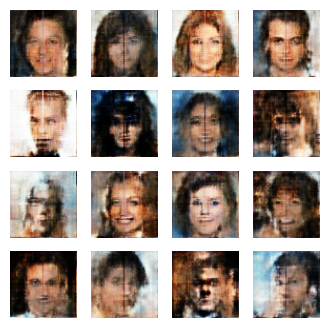

In [20]:
# change epoch_start if you are continuing training. next training with -> epoch_start + epochs
epochs = 10
epoch_start = 21

train(train_ds=data, epoch_start=epoch_start, epochs=epochs)

In [22]:
generated = wgan.generator(seed)

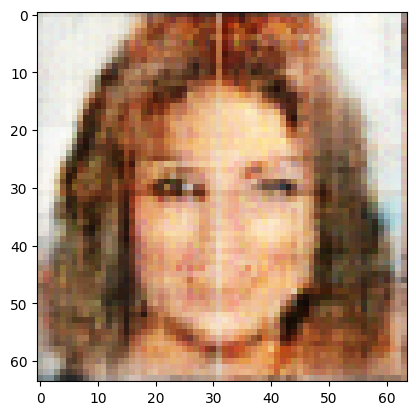

In [31]:
plt.imshow(np.clip(generated[2] * 0.5 + 0.5, 0, 1))

Generate gif

In [27]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import imageio
import glob

In [29]:
anim_file = 'wgan_gp.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-29-dca09634f024>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-29-dca09634f024>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


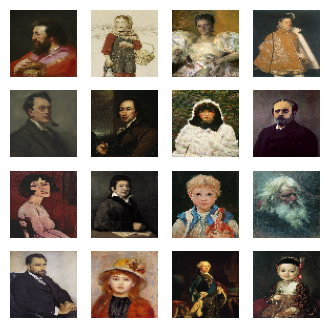

In [ ]:
fig = plt.figure(figsize=(4, 4))
temp = next(iter(data))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.clip(temp[i] * 0.5 + 0.5, 0, 1))
    plt.axis('off')

plt.show()

critic:

conv2d(channels, features, kernel=4, stride=2, padding=same)
leakyrelu(0.2)

conv2d(features, features*2, kernel=4, stride=2, padding=same)
batchnorm
leakyrelu

conv2d(features*2, features*4, kernel=4, stride=2, padding=same)
batchnorm
leakyrelu

conv2d(features*4, features*8, kernel=4, stride=2, padding=same)
batchnorm
leakyrelu

conv2d(features*8, 1, kernel=4, stride=2, padding=valid)

gen:

conv2dt(z_dim, features*16, kernel=4, stride=2, padding=valid)
batchnorm
relu

conv2dt(features*16, features*8, kernel=4, stride=2, padding=same)
batchnorm
relu

conv2dt(features*8, features*4, kernel=4, stride=2, padding=valid)
batchnorm
relu

conv2dt(features*4, features*2, kernel=4, stride=2, padding=same)
batchnorm
relu

con2dt(features*2, channels, kernel=4, stride=2, padding=same)

